```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Lake at rest

Checking that all simulators are able to preserve lake at rest given smooth non-constant bottom topography.

#### Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


import os
import pyopencl
import datetime
import sys

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce GTX 780


In [3]:
#Create output directory for images
#imgdir='images_swashes_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
#os.makedirs(imgdir)
#print "Saving images to " + imgdir

## Swashes dam break parameters - Case 4.1.1

We use a 1D domain consisting, meaning ny = 1.

In [21]:
"""
Generates a smooth bottom topography
"""
def make2DBottomTopography(h, H0, nx, ny, dx, dy, halo):
    for j in range(0, ny+halo[0]+halo[2]):
        y = (j-halo[2])/(4*np.pi)
        for i in range(0, nx+halo[1]+halo[3]):
            x = (i-halo[3])/(4*np.pi)
            h[j,i] = H0 + 0.2*(np.cos(y) + np.sin(x))



In [37]:
# Simulation parameters:

nx = 200
ny = 200
dx = 1.0
dy = 1.0

dt = 0.1
T1 = 10.0
T2 = 100.0
T3 = 1000.0

# Other paramters:
g = 9.81
f = 0.0
r = 0.0
A = 0.0

H0 = 1.0


-------------- KP07 -------------- 
T1 = 10.0
-- at time 10.0 --
Max/min eta:  7.51996e-08 -7.87547e-08
Max/min hu :  4.78327e-07 -5.69224e-07
Max/min hv :  5.09247e-07 -5.02914e-07
T2 = 100.0
-- at time 109.999 --
Max/min eta:  7.4329e-08 -8.03523e-08
Max/min hu :  5.81238e-07 -5.68665e-07
Max/min hv :  6.17653e-07 -5.75556e-07
T3 = 1000.0
-- at time 1109.88 --
Max/min eta:  8.04531e-08 -9.56204e-08
Max/min hu :  8.0317e-07 -7.93964e-07
Max/min hv :  6.97281e-07 -7.26528e-07
-------------- CDKLM -------------- 
T1 = 10.0
-- at time 99.999 --
Max/min eta:  1.00788e-07 -1.05979e-07
Max/min hu :  2.86176e-06 -2.70679e-06
Max/min hv :  2.82566e-06 -2.58287e-06
T2 = 100.0
-- at time 200.003 --
Max/min eta:  1.17403e-07 -1.12483e-07
Max/min hu :  3.23874e-06 -3.12179e-06
Max/min hv :  3.39452e-06 -2.70156e-06
T3 = 1000.0
-- at time 1199.85 --
Max/min eta:  9.9341e-08 -1.16944e-07
Max/min hu :  4.52014e-06 -4.69661e-06
Max/min hv :  5.19447e-06 -5.06658e-06
-------------- CTCS --------------

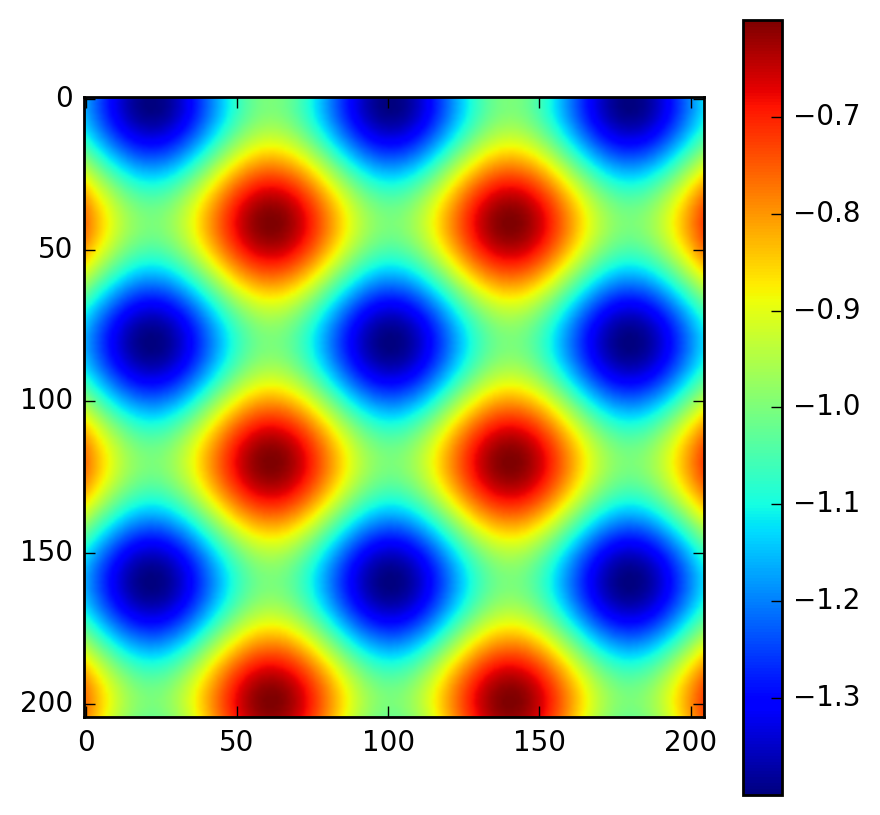

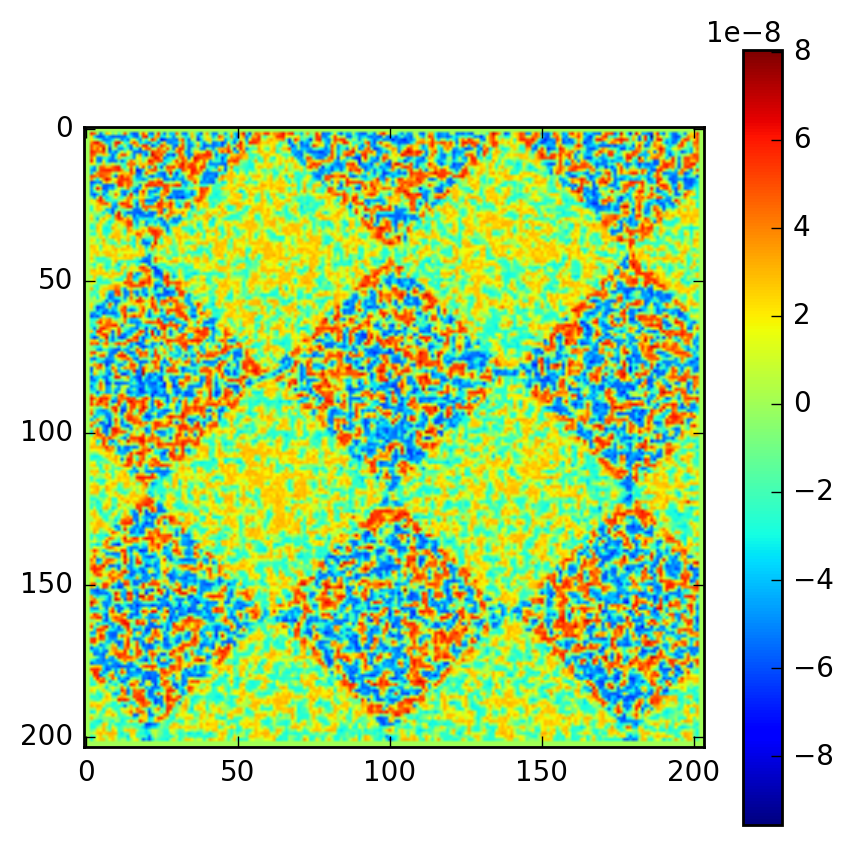

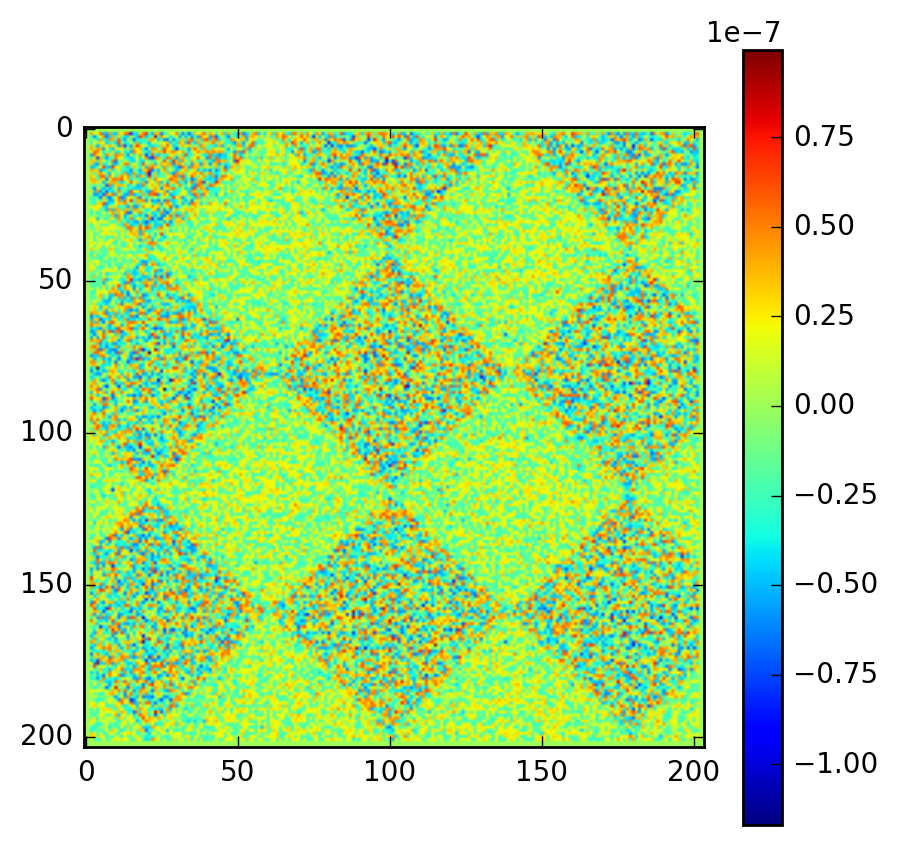

In [40]:
def printStats(eta, hu, hv, t):
    print "-- at time " + str(t) + " --"
    print "Max/min eta: ", np.max(eta), np.min(eta)
    print "Max/min hu : ", np.max(hu),  np.min(hu)
    print "Max/min hv : ", np.max(hv),  np.min(hv)



## Non-staggered:
boundaryConditions = Common.BoundaryConditions()
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
make2DBottomTopography(Hi, H0, nx+1, ny+1, dx, dy, ghosts)

fig = plt.figure(figsize=(5,5))
plt.imshow(-Hi)
plt.colorbar()


# KP07
sim = KP07.KP07(cl_ctx, \
                eta0, Hi, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, \
                boundary_conditions=boundaryConditions)

print "-------------- KP07 -------------- "
print "T1 = " + str(T1)
t_kp07 = sim.step(T1)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)
print "T2 = " + str(T2)
t_kp07 = sim.step(T2)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)
print "T3 = " + str(T3)
t_kp07 = sim.step(T3)
eta_kp07, hu_kp07, hv_kp07 = sim.download()
printStats(eta_kp07, hu_kp07, hv_kp07, t_kp07)

fig = plt.figure(figsize=(5,5))
plt.imshow(eta_kp07)
plt.colorbar()


# CDKLM16
sim = CDKLM16.CDKLM16(cl_ctx, \
                      eta0, u0, v0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, \
                      boundary_conditions=boundaryConditions)
print "-------------- CDKLM -------------- "
print "T1 = " + str(T1)
t_cdklm = sim.step(T2)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)
print "T2 = " + str(T2)
t_cdklm = sim.step(T2)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)
print "T3 = " + str(T3)
t_cdklm = sim.step(T3)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()
printStats(eta_cdklm, hu_cdklm, hv_cdklm, t_cdklm)

fig = plt.figure(figsize=(5,5))
plt.imshow(eta_cdklm)
plt.colorbar()


## Staggered CTCS
ghosts = [1,1,1,1] # north, east, south, west
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
h0 = np.ones(dataShape, dtype=np.float32, order='C') 
eta0_ctcs = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');    
make2DBottomTopography(h0, H0, nx, ny, dx, dy, ghosts)

ctcs_sim = CTCS.CTCS(cl_ctx, \
                     h0, eta0_ctcs, u0, v0, \
                     nx, ny, dx, dy, dt, \
                     g, f, r, A, \
                     boundary_conditions=boundaryConditions )

print "-------------- CTCS -------------- "
print "T1 = " + str(T1)
t_ctcs = ctcs_sim.step(T1)
eta_ctcs, hu_ctcs, hv_ctcs = ctcs_sim.download()
printStats(eta_ctcs, hu_ctcs, hv_ctcs, t_ctcs)
print "T2 = " + str(T2)
t_ctcs = ctcs_sim.step(T2)
eta_ctcs, hu_ctcs, hv_ctcs = ctcs_sim.download()
printStats(eta_ctcs, hu_ctcs, hv_ctcs , t_ctcs)


## Staggered FBL
ghosts = [0,0,0,0]
#validDomain = [None, None, 0, 0]    
boundaryConditions = Common.BoundaryConditions()
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

h0 = np.ones(dataShape, dtype=np.float32, order='C')
eta0_fbl = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');
make2DBottomTopography(h0, H0, nx, ny, dx, dy, ghosts)

fbl_sim = FBL.FBL(cl_ctx, \
                  h0, eta0_fbl, u0, v0, \
                  nx, ny, \
                  dx, dy, dt, \
                  g, f, r, \
                  boundary_conditions=boundaryConditions)
#t = ctcs_sim.step(dt*370)
print "-------------- FBL -------------- "
print "T1 = " + str(T1)
t_fbl = fbl_sim.step(T1)
eta_fbl, hu_fbl, hv_fbl = fbl_sim.download()
printStats(eta_fbl, hu_fbl, hv_fbl, t_fbl)
print "T2 = " + str(T2)
t_fbl = fbl_sim.step(T2)
eta_fbl, hu_fbl, hv_fbl = fbl_sim.download()
printStats(eta_fbl, hu_fbl, hv_fbl, t_fbl)

#